In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.extensions import RXGate, RZGate
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit import  execute, BasicAer
import qiskit.quantum_info as qi
import scipy.optimize 
import random
import matplotlib.pyplot as plt
import pickle
import os 
import h5py 
import pandas as pd
import uproot
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time


from qiskit.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA
from IPython.display import clear_output
from qiskit import  execute, BasicAer
from qiskit_machine_learning.circuit.library import RawFeatureVector

from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import RealAmplitudes,EfficientSU2
from sklearn.utils import shuffle
import pandas as pd

In [2]:
def callback_graph(weights, obj_func_eval):
    print(len(objective_func_vals))
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    
    
def produceDataset(inputFileName,path,treeName):
    
    print("start preparing",inputFileName)
    file = uproot.open(path+inputFileName+".root")
    tree=file[treeName]
    VariableList=tree.keys()
    

    df = tree.arrays(filter_name=VariableList[0],library="pd") 
    for i in range(1,len(VariableList)):
        df=df.join(tree.arrays(filter_name=VariableList[i],library="pd"))



    return df

def getFourVector(pt,eta,phi):
   
    m=1 # precision issues. not sure why but m=1 makes that no negative invariant mass square.
    px=pt*np.cos(phi)
    py=pt*np.sin(phi)
    pz=pt*np.sinh(eta)
    E=np.sqrt(px**2+py**2+pz**2+m**2)
    return np.array([E,px,py,pz], dtype=np.float64)

def getInvM(v):
    m2=v[0]**2-v[1]**2-v[2]**2-v[3]**2
    
    return np.sqrt(m2)

def getMass(df):
    v1=getFourVector(df['f_lept1_pt'],df['f_lept1_eta'],df['f_lept1_phi'])
    v2=getFourVector(df['f_lept2_pt'],df['f_lept2_eta'],df['f_lept2_phi'])
    v3=getFourVector(df['f_lept3_pt'],df['f_lept3_eta'],df['f_lept3_phi'])
    v4=getFourVector(df['f_lept4_pt'],df['f_lept4_eta'],df['f_lept4_phi'])
    v=v1+v2+v3+v4
    m_reco=getInvM(v)
    return m_reco

def getThreeVectors_df(df):
    v1=getFourVector(df['f_lept1_pt'],df['f_lept1_eta'],df['f_lept1_phi'])
    v2=getFourVector(df['f_lept2_pt'],df['f_lept2_eta'],df['f_lept2_phi'])
    v3=getFourVector(df['f_lept3_pt'],df['f_lept3_eta'],df['f_lept3_phi'])
    v4=getFourVector(df['f_lept4_pt'],df['f_lept4_eta'],df['f_lept4_phi'])
    

    output=np.concatenate([v1[1:],v2[1:],v3[1:],v4[1:]])
    return  np.transpose(output)

def getDot_df(df):
    v1=getFourVector(df['f_lept1_pt'],df['f_lept1_eta'],df['f_lept1_phi'])
    v2=getFourVector(df['f_lept2_pt'],df['f_lept2_eta'],df['f_lept2_phi'])
    v3=getFourVector(df['f_lept3_pt'],df['f_lept3_eta'],df['f_lept3_phi'])
    v4=getFourVector(df['f_lept4_pt'],df['f_lept4_eta'],df['f_lept4_phi'])
    
    dot=[]

    dot.append(getInvM(v1+v1))
    dot.append(getInvM(v2+v2))
    dot.append(getInvM(v3+v3))
    dot.append(getInvM(v4+v4))
    
    dot.append(getInvM(v1+v2))
    dot.append(getInvM(v1+v3))
    dot.append(getInvM(v1+v4))
    dot.append(getInvM(v2+v3))
    dot.append(getInvM(v2+v4))
    dot.append(getInvM(v3+v4))
    dot=np.array(dot)
    

    return np.transpose(dot)
    

In [3]:

nShots=2**12
nMaxIter=300
method="COBYLA"
maxDatasetEvents=5000

Dir="/Users/lizhelun/Desktop/QC/Datasets/"

h4l_VV="ntuple_4mu_VV"
h4l_bkg="ntuple_4mu_bkg"

print("nShots = ",nShots)

nShots =  4096


In [4]:
h4l=produceDataset(h4l_VV,Dir,'HZZ4LeptonsAnalysisReduced')

start preparing ntuple_4mu_VV


In [5]:
bkg=produceDataset(h4l_bkg,Dir,'HZZ4LeptonsAnalysisReduced')

start preparing ntuple_4mu_bkg


In [6]:
m_reco_signal=getMass(h4l)
m_reco_bkg=getMass(bkg)

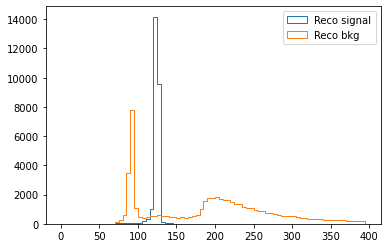

In [7]:
#h4l['f_mass4l'].hist(bins=np.arange(100,150,1),label='truth');
plt.hist(m_reco_signal,bins=np.arange(0,400,5),histtype='step',label='Reco signal');
plt.hist(m_reco_bkg,bins=np.arange(0,400,5),histtype='step',label='Reco bkg');
plt.legend()

In [8]:
sig_3vec=getThreeVectors_df(h4l)
bkg_3vec=getThreeVectors_df(bkg)

In [9]:
sig_dot=getDot_df(h4l)
bkg_dot=getDot_df(bkg)

In [10]:
def split(X,y):
    train_ratio=0.6
    X_train, X_valTest, y_train, y_valTest = train_test_split(X.copy(), y.copy(), train_size=train_ratio, random_state=100)
    X_val, X_test, y_val, y_test = train_test_split(X_valTest, y_valTest, test_size=0.5, random_state=200)
    #Normalizing everythings:
    X_train=X_train/X_train.max()
    X_val=X_val/X_val.max()
    X_test=X_test/X_test.max()
    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [11]:
X_3=np.concatenate([sig_3vec[0:maxDatasetEvents],bkg_3vec[0:maxDatasetEvents]])
y_3=np.concatenate([np.ones(sig_3vec[0:maxDatasetEvents].shape[0]),-1*np.ones(bkg_3vec[0:maxDatasetEvents].shape[0])])
X_3,y_3=shuffle(X_3,y_3,random_state=1000)

X_train_3,y_train_3,X_val_3,y_val_3,X_test_3,y_test_3=split(X_3,y_3)

In [12]:
X_dot=np.concatenate([sig_dot[0:maxDatasetEvents],bkg_dot[0:maxDatasetEvents]])
y_dot=np.concatenate([np.ones(sig_dot[0:maxDatasetEvents].shape[0]),-1*np.ones(bkg_dot[0:maxDatasetEvents].shape[0])])
X_dot,y_dot=shuffle(X_dot,y_dot,random_state=1000)

X_train_dot,y_train_dot,X_val_dot,y_val_dot,X_test_dot,y_test_dot=split(X_dot,y_dot)

In [13]:
from qiskit.circuit.library import ZZFeatureMap,ZFeatureMap
from qiskit.circuit import ParameterVector

from qiskit.quantum_info import SparsePauliOp

from qiskit_machine_learning.neural_networks import EstimatorQNN

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR



maxEvents=500
MaxIter=300

No symmetry

In [14]:
nLayer_realAmplitude=2
num_qubits=X_3.shape[1]
n_inputParams=num_qubits
n_params=nLayer_realAmplitude*num_qubits
N_particles=4
print(num_qubits)


12


In [15]:
qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)
feature_map = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")
ansatz=RealAmplitudes(num_qubits, reps=nLayer_realAmplitude)


qc.compose(feature_map, inplace=True) 
qc.compose(ansatz,inplace=True)    


In [16]:
observable1 = SparsePauliOp.from_list([("Z" * num_qubits, 1)])
estimator_qnn = EstimatorQNN(
    circuit=qc, observables=observable1, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

estimator_classifier_baseline = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=MaxIter), callback=callback_graph
)



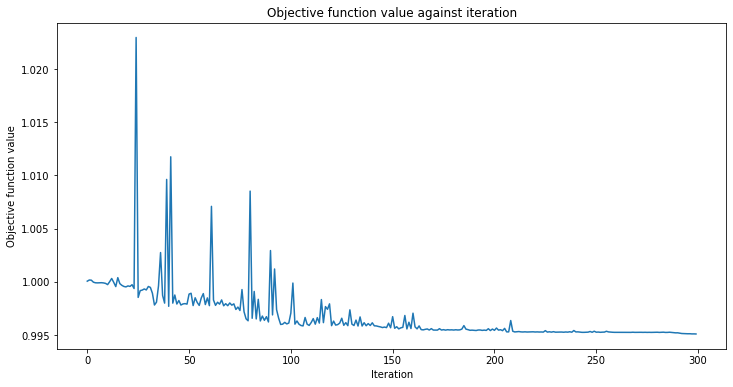

In [17]:



objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier_baseline.fit(X_train_3[0:maxEvents],y_train_3[0:maxEvents])

# return to default figsize
# plt.rcParams["figure.figxsize"] = (6, 4)



In [18]:
# score classifier
print("training score = ",estimator_classifier_baseline.score(X_train_3[0:maxEvents], y_train_3[0:maxEvents]))
print("test score = ",estimator_classifier_baseline.score(X_test_3[0:2*maxEvents], y_test_3[0:2*maxEvents]))


training score =  0.552
test score =  0.558


Rotation only

In [19]:

num_layers=2
N_particles=4
num_qubits=int((N_particles+1)*N_particles/2)
n_params=num_layers*num_qubits
zeroState = '0'
for i in range(num_qubits-1):
    zeroState+='0'
def countZero(x):
    return f"{bin(x)}".count("0")%(num_qubits+1)

In [20]:
qr_rot = QuantumRegister(num_qubits)
qc_rot = QuantumCircuit(qr_rot)
feature_map_rot = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")
ansatz_rot=RealAmplitudes(num_qubits, reps=nLayer_realAmplitude)


inputParams_index=0
params_index=0


qc_rot.compose(feature_map_rot, inplace=True) 
qc_rot.compose(ansatz_rot,inplace=True)    


In [21]:
observable1_rot = SparsePauliOp.from_list([("Z" * num_qubits, 1)])
estimator_qnn_rot = EstimatorQNN(
    circuit=qc_rot, observables=observable1_rot, input_params=feature_map_rot.parameters, weight_params=ansatz_rot.parameters
)
estimator_classifier_rot = NeuralNetworkClassifier(
    estimator_qnn_rot, optimizer=COBYLA(maxiter=MaxIter), callback=callback_graph
)



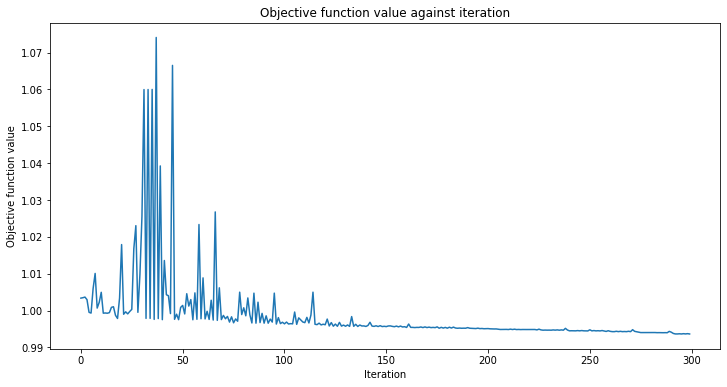

training score =  0.588
test score =  0.547


In [22]:



objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier_rot.fit(X_train_dot[0:maxEvents], y_train_dot[0:maxEvents])

# return to default figsize
# plt.rcParams["figure.figxsize"] = (6, 4)
# score classifier
print("training score = ",estimator_classifier_rot.score(X_train_dot[0:maxEvents], y_train_dot[0:maxEvents]))
print("test score = ",estimator_classifier_rot.score(X_test_dot[0:2*maxEvents], y_test_dot[0:2*maxEvents]))

Rotation + Permutation

In [23]:

num_layers=2
# n_inputParams=num_qubits
n_params=num_layers*4
N_particles=4
num_qubits=int((N_particles+1)*N_particles/2)

In [24]:

qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)
feature_map = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")


weights = ParameterVector("weight", n_params)
print(f"weight parameters: {[str(item) for item in weights.params]}")

inputParams_index=0
params_index=0


qc.compose(feature_map, inplace=True) 
   
for layer in range(num_layers):
    
        for i in range(N_particles):
            qc.ry(weights[params_index],i)
            
        params_index += 1 
        
        for i in range(N_particles):
            for k in np.arange(i,N_particles,1):
                if i!=k:
                    qc.rzz(weights[params_index],i,k)
            
            
        params_index += 1
        for j in np.arange(N_particles,num_qubits,1):
            qc.ry(weights[params_index],j)
        params_index += 1
        
        for i in np.arange(N_particles,num_qubits,1):
            for k in np.arange(i,num_qubits,1):
                if i!=k:
                    qc.rzz(weights[params_index],i,k)
                    
        params_index += 1
            
        
        qc.barrier()

weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]', 'weight[4]', 'weight[5]', 'weight[6]', 'weight[7]']


In [25]:

observable1 = SparsePauliOp.from_list([("Z" * num_qubits, 1)])
estimator_qnn = EstimatorQNN(
    circuit=qc, observables=observable1, input_params=feature_map.parameters, weight_params=weights
)

estimator_classifier_rotPerm = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=MaxIter), callback=callback_graph
)

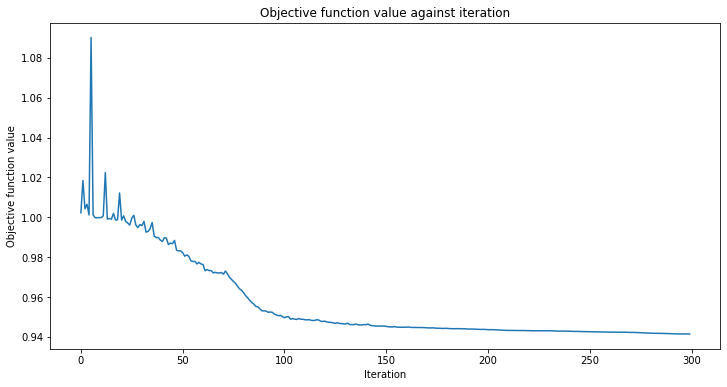

training score =  0.834
test score =  0.761


In [26]:



objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier_rotPerm.fit(X_train_dot[0:maxEvents], y_train_dot[0:maxEvents])

# return to default figsize
# plt.rcParams["figure.figxsize"] = (6, 4)
# score classifier
print("training score = ",estimator_classifier_rotPerm.score(X_train_dot[0:maxEvents], y_train_dot[0:maxEvents]))
print("test score = ",estimator_classifier_rotPerm.score(X_test_dot[0:2*maxEvents], y_test_dot[0:2*maxEvents]))